In [1]:
import cv2
import glob
import numpy as np
print("OpenCV version :  {0}".format(cv2.__version__))

OpenCV version :  3.4.2


# Step (1): Load the images and camera parameters.
This is the same as task 3 step (1), and we use the same image paris as those in task 3. In this task, you are required to use two views obtained from the stereo camera system, e.g., using "left_0.png" and "right_0.png". Several pairs of images are provided in the project resource folder. You also need to load the camera parameters in task 2. Note that for this task, the two views must be rectified.

### load images and parameters

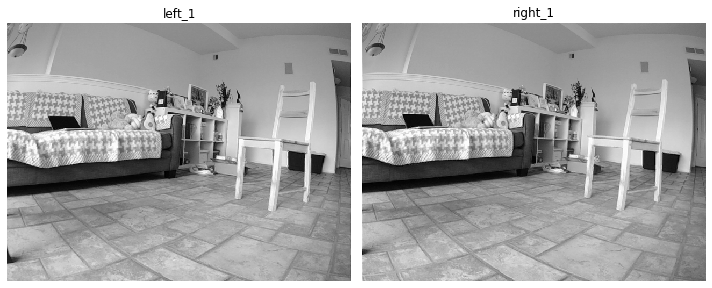

In [2]:
left_ = [cv2.imread(image, 0) for image in sorted(glob.glob("../../images/task_3_and_4/left_*.png"))]
right_ = [cv2.imread(image, 0) for image in sorted(glob.glob("../../images/task_3_and_4/right_*.png"))]

import matplotlib.pyplot as plt
def plot_figures(figures, nrows=1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10,10))
    if(nrows > 1 or ncols > 1):
        for ind,title in enumerate(figures):
            axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
            axeslist.ravel()[ind].set_title(title)
            axeslist.ravel()[ind].set_axis_off()
        plt.tight_layout() # optional
    else:
        for ind,title in enumerate(figures):
            axeslist.imshow(figures[title], cmap=plt.gray())
            axeslist.set_title(title)
            axeslist.set_axis_off()
            

plot_figures({'left_1': left_[6], 'right_1': right_[6]}, 1, 2)

s = cv2.FileStorage('../../parameters/left_camera_intrinsics.xml', cv2.FileStorage_READ)

mtx_left = s.getNode('mtx_left').mat()
distCoeffs_left = s.getNode('distCoeffs_left').mat()
s.release()


s = cv2.FileStorage('../../parameters/right_camera_intrinsics.xml', cv2.FileStorage_READ)

mtx_right = s.getNode('mtx_right').mat()
distCoeffs_right = s.getNode('distCoeffs_right').mat()
s.release()


s = cv2.FileStorage('../../parameters/stereo_calibration.xml', cv2.FileStorage_READ)
R = s.getNode('R').mat()
T = s.getNode('T').mat()
E = s.getNode('E').mat()
F = s.getNode('F').mat()


s = cv2.FileStorage('../../parameters/stereo_rectification.xml', cv2.FileStorage_READ)
R1 = s.getNode('R1').mat()
R2 = s.getNode('R2').mat()
P1 = s.getNode('P1').mat()
P2 = s.getNode('P2').mat()
Q = s.getNode('Q').mat()
roi1 = s.getNode('roi1').mat()
roi2 = s.getNode('roi2').mat()

In [3]:
# for i in range(len(left_)):
#     plot_figures({'left_1': left_[i], 'right_1': right_[i]}, 1, 2)

### undistort and rectify

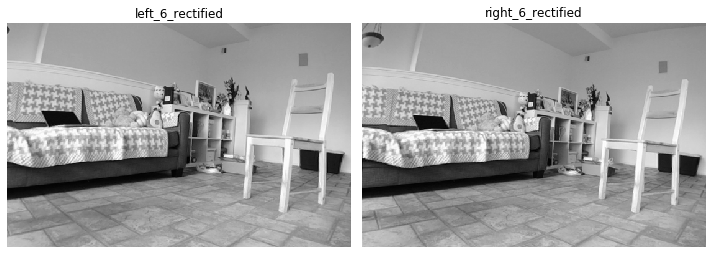

In [4]:
h, w = left_[1].shape[:2]

newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx_left, distCoeffs_left, (w,h), 1, (w,h))
x,y,w,h = roi
mapx,mapy = cv2.initUndistortRectifyMap(mtx_left,distCoeffs_left,None,newcameramtx,(w,h),5)
left_6_rectified = cv2.remap(left_[6].copy(),mapx,mapy,cv2.INTER_LINEAR)[y:y+h, x:x+w]

newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx_right, distCoeffs_right, (w,h), 1, (w,h))
x,y,w,h = roi
mapx,mapy = cv2.initUndistortRectifyMap(mtx_right,distCoeffs_right,None,newcameramtx,(w,h),5)
right_6_rectified = cv2.remap(right_[6].copy(),mapx,mapy,cv2.INTER_LINEAR)
right_6_rectified = right_6_rectified[y:y+h+10, x:x+w]
left_6_rectified = left_6_rectified[18:y+h-44, 30:x+w-20]

plot_figures({'left_6_rectified':left_6_rectified, 'right_6_rectified':right_6_rectified},1,2)

In [5]:
left_6_rectified.shape, right_6_rectified.shape

((361, 554), (361, 554))

# Step (2): Block match for each pixel on the images to obtain a disparity map. 
Use the OpenCV "StereoBM" class or the "StereoSGBM" class to compute the disparity map of the two views. Note that the two images must be undistorted with the rectification parameters, which is the same as that in task 2 step (6). Note that this method has limitations. For example, in those image regions without much texture, disparity would be invalid, i.e., no matches or spurious matches. The disparity map may not cover the whole image but only those parts overlapped by the two views. You can tune the block matching parameters to improve the quality of the disparity map. However, with a fixed baseline length, the same parameter setting may not work for all scenes.

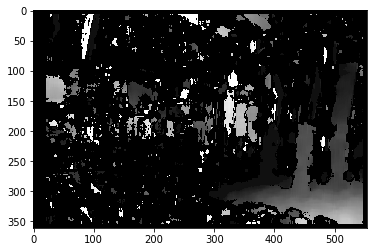

In [6]:
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(left_6_rectified,right_6_rectified)
plt.imshow(disparity,'gray')

In [7]:
disparity

array([[-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       ...,
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16],
       [-16, -16, -16, ..., -16, -16, -16]], dtype=int16)

# Step (3): Calculate depth for each pixel using the disparity map. 
Another way is just use the OpenCV library function "reprojectImageTo3D()".

cv2.reprojectImageTo3D(disparity, Q[, _3dImage[, handleMissingValues[, ddepth]]]) → _3dImage¶

In [8]:
_3dImage = cv2.reprojectImageTo3D(disparity=disparity, Q=Q)
_3dImage.shape

(361, 554, 3)

# Step (4): Check the dense depth results. 
You can write a program to show the disparity image and the depth image to verify the calculation, like the example shown in Figure 13. Note that you may not be able to obtain satisfying results with all scenes.

### Try to plot 3D points

In [9]:
x = _3dImage.transpose()[0].flatten()
y = _3dImage.transpose()[1].flatten()
z = _3dImage.transpose()[2].flatten()

In [10]:
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(x,y,z)
# plt.show()

something isn't right about that plot...

### try something else

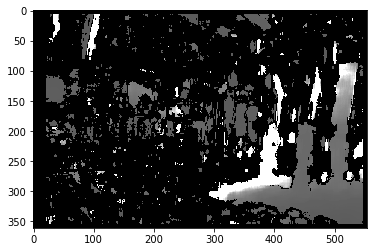

In [11]:
z = _3dImage.transpose()[2].copy()
z = z.transpose()

plt.imshow(z,'gray')

In [12]:
cv2.imwrite('../../output/task_4/left_right_4_disparity.png', disparity)
cv2.imwrite('../../output/task_4/left_right_4_3D.png', z)

True

In [13]:
for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        if z[i][j] > 1000:
            z[i][j] = 0

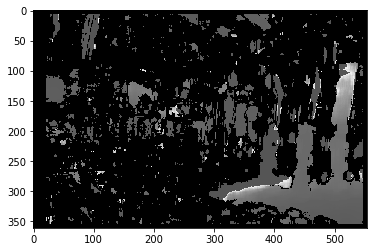

In [14]:
plt.imshow(z,'gray')

### create more examples

In [15]:
# for i in range(len(left_)):
#     h, w = left_[i].shape[:2]

#     newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx_left, distCoeffs_left, (w,h), 1, (w,h))
#     x,y,w,h = roi
#     mapx,mapy = cv2.initUndistortRectifyMap(mtx_left,distCoeffs_left,None,newcameramtx,(w,h),5)
#     left_6_rectified = cv2.remap(left_[i].copy(),mapx,mapy,cv2.INTER_LINEAR)[y:y+h, x:x+w]

#     newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx_right, distCoeffs_right, (w,h), 1, (w,h))
#     x,y,w,h = roi
#     mapx,mapy = cv2.initUndistortRectifyMap(mtx_right,distCoeffs_right,None,newcameramtx,(w,h),5)
#     right_6_rectified = cv2.remap(right_[i].copy(),mapx,mapy,cv2.INTER_LINEAR)
#     right_6_rectified = right_6_rectified[y:y+h+i, x:x+w]
#     left_6_rectified = left_6_rectified[18:y+h-44, 30:x+w-20]

#     plot_figures({'left_6_rectified':left_6_rectified, 'right_6_rectified':right_6_rectified},1,2)

#     stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
#     disparity = stereo.compute(left_6_rectified,right_6_rectified)
#     plt.imshow(disparity,'gray')

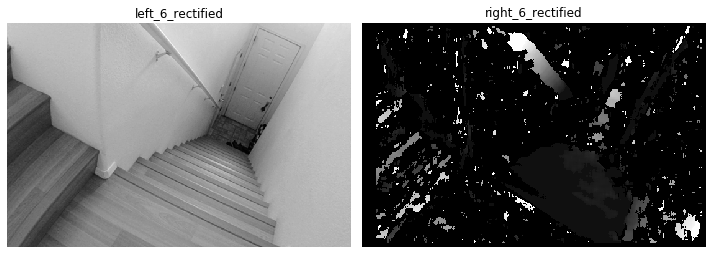

In [16]:
i = 11
h, w = left_[i].shape[:2]

newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx_left, distCoeffs_left, (w,h), 1, (w,h))
x,y,w,h = roi
mapx,mapy = cv2.initUndistortRectifyMap(mtx_left,distCoeffs_left,None,newcameramtx,(w,h),5)
left_6_rectified = cv2.remap(left_[i].copy(),mapx,mapy,cv2.INTER_LINEAR)[y:y+h, x:x+w]

newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx_right, distCoeffs_right, (w,h), 1, (w,h))
x,y,w,h = roi
mapx,mapy = cv2.initUndistortRectifyMap(mtx_right,distCoeffs_right,None,newcameramtx,(w,h),5)
right_6_rectified = cv2.remap(right_[i].copy(),mapx,mapy,cv2.INTER_LINEAR)
right_6_rectified = right_6_rectified[y:y+h+i, x:x+w]
left_6_rectified = left_6_rectified[18:y+h-44, 30:x+w-20]

plot_figures({'left_6_rectified':left_6_rectified, 'right_6_rectified':right_6_rectified},1,2)

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(left_6_rectified,right_6_rectified)
plt.imshow(disparity,'gray')

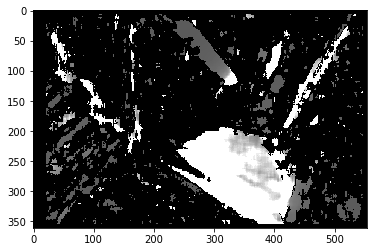

In [19]:
_3dImage = cv2.reprojectImageTo3D(disparity=disparity, Q=Q)

z = _3dImage.transpose()[2].copy()
z = z.transpose()

plt.imshow(z,'gray')
plt.show()

In [18]:
cv2.imwrite('../../output/task_4/left_right_9_disparity.png', disparity)
cv2.imwrite('../../output/task_4/left_right_9_3D.png', z)

True